# K-Nearest Neighbours Classification of Heart Disease

Data downloaded from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/heart+Disease

Original data seen from Kaggle at https://www.kaggle.com/ronitf/heart-disease-uci. This data is edited and is incorrect, so is not used.

## Importing Packages

In [1]:
##Import packages

#Data Processing
import pandas as pd
import numpy as np

#Finding the data on our system
import pathlib

#KNN
from sklearn.neighbors import KNeighborsClassifier

#Scaling
from sklearn.preprocessing import StandardScaler

#Cross-validation
from sklearn.model_selection import GridSearchCV

#Splitting data into training and test
from sklearn.model_selection import train_test_split

#Metrics to evaluate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Plotting library
import matplotlib.pyplot as plt

## Import Data

### Understanding the Dataset

When you collect your own data, you should know exactly what each of the variables represent, and how the variables are encoded. Unfortunately, when working with others' data, we don't start with a full understanding of the data. Not being able to understand the data makes it extremely difficult to gain insight from it. You should definitely document any data of your own, as you might have to come back to it later, or someone else might have to interpret it in the future.

As it turns out with the original dataset that was planned to be used in this example ([Kaggle Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci)), it is also important to check the integrity of the dataset, especially if we plan to use the insights that we extract from the data. Resulting from investigation of the data, it seems that this source has edited data, and is misleading in various areas (for example, the indicator variable values for heart disease were swapped!). Therefore, we swap to using a correct version of the dataset, cited by multiple papers using this: [UCI Machine Learning Repository Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease). This illustrates just how important it is to be able to trust our datasets if we're planning to use them.

At the UCI Machine Learning Repository, there is an accurate description of every column, of which only 14 are used (we will keep with this convention and only use these columns). The description of these columns is given as follows, to help our understanding:


- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
1. Value 1: typical angina
2. Value 2: atypical angina
3. Value 3: non-anginal pain
4. Value 4: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg: resting electrocardiographic results
0. Value 0: normal
1. Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
2. Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
1. Value 1: upsloping
2. Value 2: flat
3. Value 3: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- num: diagnosis of heart disease (angiographic disease status)
0. Value 0: < 50% diameter narrowing (No disease)
1. Value 1-4: > 50% diameter narrowing (Disease)

The "num" variable is used as our target value, and as described in the description of the dataset, non-zero values here indicate disease. Therefore, we can later transform our dataset to have either a 0, or a 1 for any disease.

### Importing the Data from the CSV File

In [2]:
##Import data from another directory

#Define the columns as described
cols = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "num"
]


#Find the file from a local directiory
p = str(pathlib.Path().resolve()).replace("\\Notebooks\\Classification Methods", "")
p += ("\\Data\\Raw\\Heart_Disease_UCI.csv")
p = pathlib.Path(p).resolve()

#Read into a pandas dataframe
df = pd.read_csv(p, names=cols)

#Preview the dataset
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Basic Data Exploration

In [3]:
#Display basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [4]:
#Transform the target variable "num" into an indicator variable
df["num"] = [0 if i == 0 else 1 for i in df["num"]]

Notice that we have a few weird values in the dataset, such as this one. We can't use these datapoints for our analysis, and there are only a couple of them, so we will drop these rows. From our call of `df.info()`, we can see that these are in the "ca" and "thal" columns (because the data-type is object, meaning anything can occupy the position, rather than float64, specifying a decimal number), so we remove rows containing non-numeric values in these columns.

In [5]:
#Show weird value
df["thal"][266]

'?'

In [6]:
#Remove non-numeric datapoints
df = df[pd.to_numeric(df["ca"], errors='coerce').notnull()]
df = df[pd.to_numeric(df["thal"], errors='coerce').notnull()]

#Change columns to numeric
df["ca"] = pd.to_numeric(df["ca"])
df["thal"] = pd.to_numeric(df["thal"])

#Show our summary again, to check if our conversion worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


## Data Transformation

### One-Hot Encoding

The data that we have has several categorical variables, which, although represented numerically, do need to be encoded. These variables have more than 2 categories that datapoints are fit into (those with 2 categories are already effectively encoded), which includes:
- cp
- restecg
- slope
- thal
- ca

We one-hot encode these using a built-in Pandas function `pd.get_dummies()`. We don't yet add these variables back into the DataFrame because of the scaling step that we will perform later, that is not appropriate for categorical variables such as these. Later, we will reconstruct a full DataFrame, such that we can train our model.

In [7]:
#One-hot encoding
cp_dummies = pd.get_dummies(df["cp"], prefix="cp")
restecg_dummies = pd.get_dummies(df["restecg"], prefix="restecg")
slope_dummies = pd.get_dummies(df["slope"], prefix="slope")
thal_dummies = pd.get_dummies(df["thal"], prefix="thal")
ca_dummies = pd.get_dummies(df["ca"], prefix="ca")

#Drop the original variables from the DataFrame
df = df.drop(["cp", "restecg", "slope", "thal", "ca"], axis=1)
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0
...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,1
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,1
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1


### Scaling with StandardScaler

After removing the rest of the categorical variables, the next step in the process is to scale the data appropriately, so we don't give bias towards smaller variables in the machine learning. For example, if this dataset had chosen to measure cholesterol in mg/L instead of mg/dl, the measurements would be very small. In terms of nearest-neighbours, this would mean that the nearest neighbour would almost always have to be very close in this measurement, and variables with larger spread would be ignored, such as age.

We can show just how useful this is by creating a scatter-plot showing the variables "age" and "chol", to show just how impactful the difference in scale could be.

Because of this, we rescale the data, transforming it such that every variable has a mean of 0, and a standard deviation of 1. We do however keep the relative distance between the variables, keeping our measurements relative, but unitless.

In [8]:
#Removing the remaining categorical variables to be added later

cat_variables = df[["sex", "fbs", "exang"]]
y = df["num"]

df = df.drop(["sex", "fbs", "exang", "num"], axis=1)

In [9]:
df.head()

,age,trestbps,chol,thalach,oldpeak
0,63.0,145.0,233.0,150.0,2.3
1,67.0,160.0,286.0,108.0,1.5
2,67.0,120.0,229.0,129.0,2.6
3,37.0,130.0,250.0,187.0,3.5
4,41.0,130.0,204.0,172.0,1.4


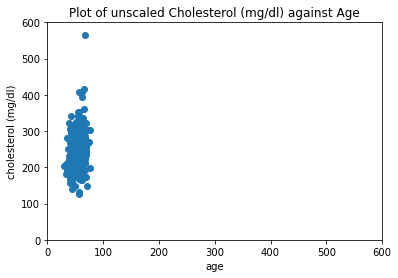

In [10]:
#Creating a scatter-plot to illustrate how necessary the scaling is

#Plot
plt.scatter(df["age"], df["chol"])

#Ensure a constant scale on both axes
plt.xlim(0, 600)
plt.ylim(0, 600)

#Labels for axes
plt.xlabel("age")
plt.ylabel("cholesterol (mg/dl)")

plt.title("Plot of unscaled Cholesterol (mg/dl) against Age")

plt.show()

As we see in the plot above, age really overpowers the cholesterol values! The closest neigbour looks to be much more determined by age than cholesterol levels, so the impact of cholesterol would be hugely underestimated if we used this data unscaled.

In [11]:
#Scaling the remaining variables

#Create the scaler object
scaler = StandardScaler()

#Fit the scaler to our dataset, then transform the data
df = scaler.fit_transform(df)

#The scaler outputs a numpy array, so we need to make it back into a DataFrame
# Note here the argument "names" from pd.read_csv becomes "columns"
df = pd.DataFrame(df, columns = ["age", "trestbps", "chol", "thalach", "oldpeak"])

df.head()

,age,trestbps,chol,thalach,oldpeak
0,0.936181,0.750380,-0.276443,0.017494,1.068965
1,1.378929,1.596266,0.744555,-1.816334,0.381773
2,1.378929,-0.659431,-0.353500,-0.899420,1.326662
3,-1.941680,-0.095506,0.051047,1.633010,2.099753
4,-1.498933,-0.095506,-0.835103,0.978071,0.295874


In [12]:
#Show that the scaling worked!
df.describe()

,age,trestbps,chol,thalach,oldpeak
count,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,297.000000
mean,-1.226105e-16,4.904420e-16,-1.958777e-16,4.784800e-16,0.000000
std,1.001688e+00,1.001688e+00,1.001688e+00,1.001688e+00,1.001688
min,-2.827176e+00,-2.125634e+00,-2.337704e+00,-3.431849e+00,-0.906712
25%,-7.241238e-01,-6.594306e-01,-7.002541e-01,-7.247694e-01,-0.906712
50%,1.613719e-01,-9.550637e-02,-8.380217e-02,1.484822e-01,-0.219520
75%,7.148067e-01,4.684179e-01,5.519138e-01,7.160957e-01,0.467672
max,2.485798e+00,3.851964e+00,6.099981e+00,2.287949e+00,4.419026


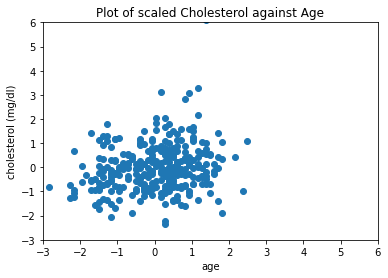

In [13]:
#Re-create our scatter-plot, to show the improvement

#Plot
plt.scatter(df["age"], df["chol"])

#Ensure a constant scale on both axes
plt.xlim(-3, 6)
plt.ylim(-3, 6)

#Labels for axes
plt.xlabel("age")
plt.ylabel("cholesterol (mg/dl)")

plt.title("Plot of scaled Cholesterol against Age")

plt.show()

### Recombine Data

Here, we recombine the data back into a single DataFrame (exlcuding the target/dependent variable "num"), such that we can fit our model to it later.

Unfortunately, after performing opertaions on the separate DataFrames, the indexes become off, such that we have to reset these for the data to realign.

In [14]:
#Reset all indexes
df = df.reset_index()
cat_variables = cat_variables.reset_index()
cp_dummies = cp_dummies.reset_index()
restecg_dummies = restecg_dummies.reset_index()
slope_dummies = slope_dummies.reset_index()
thal_dummies = thal_dummies.reset_index()
ca_dummies = ca_dummies.reset_index()

#Recombine all sources of data back into a singular DataFrame object
df = pd.concat([df, 
                cat_variables, 
                cp_dummies, 
                restecg_dummies, 
                slope_dummies, 
                thal_dummies,
                ca_dummies], ignore_index=False, axis=1)


In [15]:
df.head()

,index,age,trestbps,chol,thalach,oldpeak,index,sex,fbs,exang,...,slope_3.0,index,thal_3.0,thal_6.0,thal_7.0,index,ca_0.0,ca_1.0,ca_2.0,ca_3.0
0,0,0.936181,0.750380,-0.276443,0.017494,1.068965,0,1.0,1.0,0.0,...,1,0,0,1,0,0,1,0,0,0
1,1,1.378929,1.596266,0.744555,-1.816334,0.381773,1,1.0,0.0,1.0,...,0,1,1,0,0,1,0,0,0,1
2,2,1.378929,-0.659431,-0.353500,-0.899420,1.326662,2,1.0,0.0,1.0,...,0,2,0,0,1,2,0,0,1,0
3,3,-1.941680,-0.095506,0.051047,1.633010,2.099753,3,1.0,0.0,0.0,...,1,3,1,0,0,3,1,0,0,0
4,4,-1.498933,-0.095506,-0.835103,0.978071,0.295874,4,0.0,0.0,0.0,...,0,4,1,0,0,4,1,0,0,0


In [16]:
df = df.drop(["index"], axis=1)

In [17]:
df.shape

(297, 25)

### Test-Train Split

A vital part of machine learning is being able to test with data that the model is not trained on. This means that we can test the generalisability of our model with this data. We use SciKit-Learn's train_test_split in order to take 20% of the data at random to be test data. This method keeps the associated dependent variable values with each row of the independent variables, and also randomises the order.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)

## KNN Training

Here, we train our KNN model to classify the data. After this, we can test this on the test data, to see how well it does.

### Grid-Search Cross Validation

To avoid over-fitting to our data, and to choose a good value of K for KNN, we use a technique called cross-validation. This involves splitting our data into several "folds" (a given fraction of the data). We then choose a value of K to test, and train our data on all but one of these folds. The remaining fold is tested upon, to get a test-data accuracy score. We repeat this with each one of the folds being left out, and get an average test-data score, without using the real test data! This process is completed for each value of K that we want to test, and we take the value that scored the best on our defined metric (this time we'll use accuracy).

We can do this automatically with Scikit-Learn's GridSearchCV. Here, we search through ranges from K=1 to K=10 (remember that ranges in Python are non-inclusive at the top-end), to see which gives us the best performance. Before running this, we likely expect a value of K=2 or K=3 to appear best, as this doesn't take only the nearest point into consideration, which might be too sensitive. We also don't expect K=10 to be the best, as this takes a lot of points into account, and might miss some "areas" of classification that don't have a lot of samples in them.

More than one parameter can be changed through a grid search, but be warned that we're creating many more possibilities to check when doing so. For example, currently we test 10 different values of K, but if we wanted to test another parameter across 10 possible values too, we would suddenly have 100 possible combinations to check. You can see how this might quickly scale for more complicated implementations, where we test 1000s of possible combinations on huge datasets. This is why the absolute best machine learning implementations require such huge computational power!

In [19]:
#K-nearest neighbours object
knn = KNeighborsClassifier()

#Define the parameters that we want to test for
parameters = {"n_neighbors": list(range(1,11))}

#Define the grid-search
clf = GridSearchCV(knn, parameters)

#Fit the model
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [20]:
#View the best parameter for this model
clf.best_params_

{'n_neighbors': 6}

Surprisingly, the best value for k is 6 for this dataset. Luckily, we don't even have to retrain our model with this knowledge, as we can just predict directly with the grid-search model!

## Prediction on Test Data

Finally, we can predict against test-data to evaluate the usefulness of our model. Here, we get an accuracy of 0.6 for the test data, meaining we can predict 80% of the time if someone has heart disease. While not perfect, this could definitely be a good start when looking for a diagnosis.

### Making Predictions

In [21]:
#Predict against test and training data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

### Testing the Accuracy of Predictions

Here, we look at the proportion of cases in both the test and training dataset that are successfully classified.

In [22]:
#Accuracy score for training data
accuracy_score(y_train, y_pred_train)

0.8734177215189873

In [23]:
#Accuracy score for training data
accuracy_score(y_test, y_pred_test)

0.8

### Confusion Matrix

Another metric that we can use to show the accuracy of the prediction is by using a confusion matrix. This shows us exactly which true labels were classified as, normalised to be a proportion of the dataset. This can be extremely useful in cases with many labels, especially when things go wrong. For example, we might end up training a model that misclassifies all plants of one species as another species. In this case, we might want to collect more variables, or build a secondary classifier to differentiate these two species from each other, after they have been separated from the rest of the data.

To do this, we first map the 0 and 1 indicators contained in our true values (`y_test`), and our predicted values (`y_pred_test`) to the labels "No Disease" and "Disease".

In [24]:
#Map the 0/1 indicators into labels
map_dict = {0: "No Disease",
            1: "Disease"}


#Create a lambda function to apply this as a convertion
index_to_label = lambda n: np.array([map_dict.get(x) for x in n])

#Use this to convert our values into labels
y_test_label = index_to_label(y_test)
y_pred_test_label = index_to_label(y_pred_test)

In [25]:
#Show that the above cell worked!
y_test_label

array(['No Disease', 'No Disease', 'Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'No Disease', 'Disease', 'No Disease',
       'Disease', 'No Disease', 'No Disease', 'Disease', 'Disease',
       'No Disease', 'Disease', 'No Disease', 'Disease', 'Disease',
       'Disease', 'Disease', 'No Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'No Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'Disease', 'Disease', 'No Disease',
       'Disease', 'No Disease', 'Disease', 'Disease', 'No Disease',
       'No Disease', 'Disease', 'Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'No Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'Disease', 'No Disease', 'Disease',
       'Disease', 'No Disease', 'No Disease', 'No Disease', 'No Disease'],
      dtype='<U10')

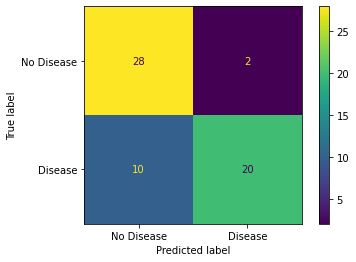

In [26]:
labels = ["No Disease", "Disease"]

#Generate the confusion matrix
cm = confusion_matrix(y_test_label, y_pred_test_label, labels = labels)

#Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

As we can see in this confusion matrix, our model is generally better when predicting cases of non-heart disease. The performance of this model isn't the best ever, but with more variables or different methods we can get better performance. Even with it as it is right now though, we could think about using it as a pre-check to see if the patient might require a further examination.